In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
torch.manual_seed(0)                    # pytorch의 난수 시드
np.random.seed(0)                       # numpy의 난수 시드

In [ ]:
# @title 하이퍼파마리터

SEQ_LEN = 40                # 입력 시퀀스의 (슬라이딩 창)길이
HIDDEN_SIZE = 1             # RNN에서 은닉상태의 차원
NUM_LAYERS = 1              # RNN에서 은닉상태의 레이어수
BATCH_SIZE = 64             #
NUM_EPOCHS = 120
LR = 1e-3

In [ ]:
t = np.linspace(0, 200, 2000, dtype=np.float32)
print(t.shape)
print(t[0])
print(t[-1])

# 사인파 코사인파 주파수를 합성
signal = np.sin(2*np.pi*1.0*t)                 # 1Hz 사인파
signal += 0.6 * np.sin(2*np.pi*3.0*t)          # 3Hz 사인파 (진폭 0.6)
signal += 0.3 * np.cos(2*np.pi*5.5*t)          # 5.5Hz 코사인파

# 저주파 진폭 변조
amp_mod = 1.0 + 0.4 * np.sin(2*np.pi*0.1 * t)
signal *= amp_mod

# 완만한 선형 추세선
signal += 0.0002 * t

# 가우시안 노이즈 추가
signal += 0.1 * np.random.randn(*t.shape)

# 단일 채널 추가 (2000, 1)
data = signal[:, np.newaxis]

print(data.shape)

(2000,)
0.0
200.0
(2000, 1)


In [ ]:
def make_sequences(arr, seq_len):
    xs, ys = [], []
    for i in range(len(arr)-seq_len):
        xs.append(arr[i : i+seq_len])           # i부터 시퀀스의 길이 만큼 데이터를 xs에 입력한다
        ys.append(arr[i+seq_len])               # xs의 바로 다음 데이터가 ys에 입력 된다
    return np.stack(xs), np.stack(ys)
X,y = make_sequences(data, SEQ_LEN)

print(X.shape)
print(y.shape)
print(X[0])

(1960, 40, 1)
(1960, 1)
[[ 0.47640523]
 [ 0.9353237 ]
 [ 0.97979325]
 [ 0.68036777]
 [ 1.5599519 ]
 [-0.09965873]
 [-1.3442357 ]
 [-0.5025896 ]
 [-1.0197358 ]
 [-1.0164726 ]
 [-0.34503534]
 [ 1.9564235 ]
 [ 0.52868974]
 [ 1.0121112 ]
 [ 1.4464984 ]
 [ 0.00589604]
 [-1.2671214 ]
 [-1.0678252 ]
 [-0.45435607]
 [-2.0675876 ]
 [ 0.18329929]
 [ 1.2842835 ]
 [ 1.2379351 ]
 [ 0.5411323 ]
 [ 1.9584998 ]
 [-0.15759254]
 [-1.7658947 ]
 [-0.57866377]
 [-1.0433396 ]
 [-1.054301  ]
 [-0.3609978 ]
 [ 2.0145402 ]
 [ 0.39443526]
 [ 0.84585696]
 [ 1.4098625 ]
 [-0.04842799]
 [-1.2504063 ]
 [-0.88193244]
 [-0.4944947 ]
 [-1.8433437 ]]


In [ ]:
# @title numpy --> tensor --> dataload
tensor_X = torch.from_numpy(X)
tensor_y = torch.from_numpy(y)

dataset = TensorDataset(tensor_X, tensor_y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# @title RNN모델
class RNN(nn.Module):
    def __init__(self, input_size=1,
                 hidden_size=HIDDEN_SIZE,
                 num_layers=NUM_LAYERS,
                 output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)            # RNN의 출력은 --> (전체output, h_n)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNN().to(device)

In [ ]:
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=LR)

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        batch_X.to(device)
        batch_y.to(device)

        opt.zero_grad()                                 # 기울기를 초기화
        pred = model(batch_X)                           # 모델의 예측 (순전파)
        loss = loss_fn(pred, batch_y)                   # loss를 계산
        loss.backward()                                 # 역전파
        opt.step()                                      # parameter 업데이트

        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(dataset)
    print(f'Epoch : {epoch} / loss : {epoch_loss}')

Epoch : 0 / loss : 1.3752593166974125
Epoch : 1 / loss : 1.3132519259744762
Epoch : 2 / loss : 1.2450706803068823
Epoch : 3 / loss : 1.1725165639604842
Epoch : 4 / loss : 1.0973414318902153
Epoch : 5 / loss : 1.0247110953136367
Epoch : 6 / loss : 0.95891965724984
Epoch : 7 / loss : 0.9024663930036584
Epoch : 8 / loss : 0.8577077121150737
Epoch : 9 / loss : 0.8235226679821404
Epoch : 10 / loss : 0.7979637291966653
Epoch : 11 / loss : 0.7786620018433551
Epoch : 12 / loss : 0.7644698469006286
Epoch : 13 / loss : 0.7531827148126096
Epoch : 14 / loss : 0.7440882196231764
Epoch : 15 / loss : 0.7359196492603847
Epoch : 16 / loss : 0.7283532108579364
Epoch : 17 / loss : 0.7207263649726401
Epoch : 18 / loss : 0.71312117284658
Epoch : 19 / loss : 0.7054625601184611
Epoch : 20 / loss : 0.6978865742683411
Epoch : 21 / loss : 0.6905349928505566
Epoch : 22 / loss : 0.6835660338401794
Epoch : 23 / loss : 0.6771430842730464
Epoch : 24 / loss : 0.671026305763089
Epoch : 25 / loss : 0.6656067558697292
E

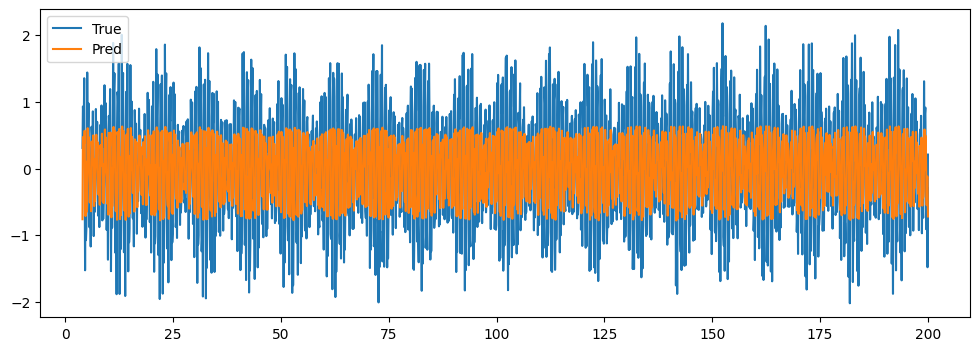

In [ ]:
model.eval()
with torch.no_grad():
    preds = model(tensor_X.to(device)).cpu().numpy()

plt.figure(figsize=(12, 4))
plt.plot(t[SEQ_LEN:], data[SEQ_LEN:, 0], label='True')
plt.plot(t[SEQ_LEN:], preds.squeeze(), label='Pred')

plt.legend()
plt.show()

In [ ]:
# @title LSTM모델
class LSTM(nn.Module):
    def __init__(self,input_size=1,
                 hidden_size=HIDDEN_SIZE,
                 num_layers=NUM_LAYERS,
                 output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x) # LSTM 출력 --> (전체 output, h_n)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM().to(device)

In [ ]:
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=LR)

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        batch_X.to(device)
        batch_y.to(device)

        opt.zero_grad()                 # 기울기를 초기화
        pred = model(batch_X)           # 모델의 예측 (순전파)
        loss = loss_fn(pred, batch_y)   # loss 계산
        loss.backward()                 # 역전파
        opt.step()                      # parameter 업데이트

        epoch_loss += loss.item() * batch_X.size(0)

    epoch_loss /= len(dataset)
    print(f"Epoch : {epoch} / loss: {epoch_loss}")

Epoch : 0 / loss: 0.8533988560949053
Epoch : 1 / loss: 0.8366632952982066
Epoch : 2 / loss: 0.8232387440545218
Epoch : 3 / loss: 0.8126725284420714
Epoch : 4 / loss: 0.8048990137723028
Epoch : 5 / loss: 0.7992174990323125
Epoch : 6 / loss: 0.7948303052357265
Epoch : 7 / loss: 0.7913435629435948
Epoch : 8 / loss: 0.7884650466393451
Epoch : 9 / loss: 0.7859965545790536
Epoch : 10 / loss: 0.7838447899234539
Epoch : 11 / loss: 0.7817244310768283
Epoch : 12 / loss: 0.7797667702850031
Epoch : 13 / loss: 0.7776086709937271
Epoch : 14 / loss: 0.7754471620734857
Epoch : 15 / loss: 0.7730070734510617
Epoch : 16 / loss: 0.770485801842748
Epoch : 17 / loss: 0.7670935861918391
Epoch : 18 / loss: 0.7633176224572318
Epoch : 19 / loss: 0.758930293637879
Epoch : 20 / loss: 0.7567321704358471
Epoch : 21 / loss: 0.7544612507430875
Epoch : 22 / loss: 0.7525746347952862
Epoch : 23 / loss: 0.7506752829162442
Epoch : 24 / loss: 0.7490317641472329
Epoch : 25 / loss: 0.747284270549307
Epoch : 26 / loss: 0.7449

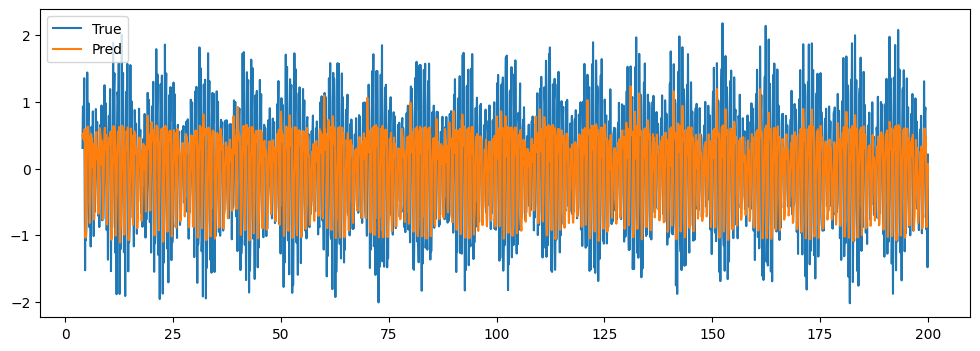

In [ ]:
model.eval()
with torch.no_grad():
    preds = model(tensor_X.to(device)).cpu().numpy()

plt.figure(figsize=(12,4))
plt.plot(t[SEQ_LEN:], data[SEQ_LEN:,0], label='True')
plt.plot(t[SEQ_LEN:], preds.squeeze(), label='Pred')

plt.legend()
plt.show()